# Cepheid Variable Analysis
### Sean Stroud

In [1]:
#Python package imports
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr, chisquare
from scipy.optimize import curve_fit
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
###Retrieving properties of cataloged Cepheids from the public Gaia table "vari_cepheid".
job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## Ripepi PL Relation

In [3]:
mw_sample = np.loadtxt('ripepi_table5.txt',usecols=(0),dtype=np.int64)
print('Total number of Milky Way Cepheids = '+str(len(mw_sample)))

Total number of Milky Way Cepheids = 2116


In [4]:
mw_subsample = np.loadtxt('ripepi_table8.txt',usecols=(3), dtype=np.int64)
print(len(mw_subsample))

301


In [5]:
lookup = 506602976101284736
#r[np.argwhere(r['source_id']==lookup)]
#r['p1_o']
#r['type_best_classification']

In [6]:
classes = []
pers = []
overs = []
for i in range(0,len(r)):
    clas = r['type_best_classification'][i]
    clas = clas[0]
    if clas != 68: #68 is one of the table's classifications for DCEPs.
        continue
    classes.append(clas)
    per = r['pf'][i]
    if str(per) == '--':
        continue
        #per = r['p1_o'][i]
    pers.append(per)
    over = r['p1_o'][i]
    if str(over) == '--':
        continue
    overs.append(over)
    #mag = r['int_average_g'][i]
    #mag = mag[0][0]

print(' Total number of Cepheids = '+str(len(r)))
print(' Total number of DCEPs = '+str(len(classes)))
print(' Number of DCEPs with fundamental periods = '+str(len(pers)))
print(' Number of DCEPs with first overtone periods = '+str(len(overs)))

 Total number of Cepheids = 9575
 Total number of DCEPs = 8890
 Number of DCEPs with fundamental periods = 5284
 Number of DCEPs with first overtone periods = 162


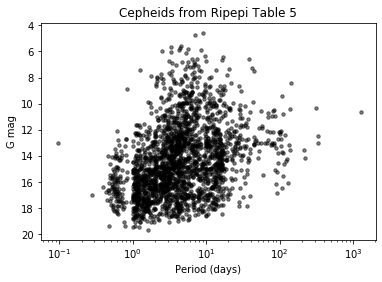

In [7]:
mw_per = np.loadtxt('ripepi_table5.txt',usecols=(6))
mw_mag = np.loadtxt('ripepi_table5.txt',usecols=(8))
plt.scatter(mw_per,mw_mag,c='k',s=12,alpha=0.5)
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('Cepheids from Ripepi Table 5')
plt.xlabel('Period (days)')
plt.ylabel('G mag')
plt.show()

In [8]:
DCEPs = []
subsamp_pers = []
subsamp_mags = []
subsamp_mag_errors = []
subsamp_ID = np.loadtxt('ripepi_table8.txt',usecols=(3), dtype=np.int64)
subsamp_mode = np.loadtxt('ripepi_table8.txt',usecols=(2),dtype=np.str)
for i in range(0,len(subsamp_ID)):
    clas = subsamp_mode[i]
    if str(clas) != 'DCEP_F':
        continue
    DCEPs.append(clas)
    ID = subsamp_ID[i]
    per = r['pf'][np.argwhere(r['source_id']==ID)]
    per = per[0][0]
    if str(per) == '--':
        #continue
        per = r['p1_o'][np.argwhere(r['source_id']==ID)]
        per = per[0][0]
    subsamp_pers.append(per)
    mag = r['int_average_g'][np.argwhere(r['source_id']==ID)]
    mag = mag[0][0]
    subsamp_mags.append(mag)
    mag_error = r['int_average_g_error'][np.argwhere(r['source_id']==ID)]
    mag_error = mag_error[0][0]
    subsamp_mag_errors.append(mag_error)
print('Subsample total size = '+str(len(subsamp_ID)))
print('Subsample with fundamental periods = '+str(len(DCEPs)))

Subsample total size = 301
Subsample with fundamental periods = 268


In [9]:
print(len(subsamp_pers))

268


In [10]:
mw_IDs = np.loadtxt('ripepi_table5.txt',usecols=(0), dtype=np.int64)
mw_IDs

array([2947530506428832768, 3315820030750497536, 4044404165342126848, ...,
       5594517472269659264, 5618290567233509120, 3060568062769059840],
      dtype=int64)

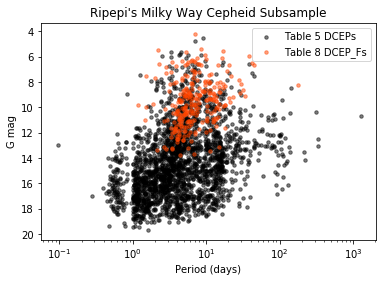

In [11]:
plt.scatter(mw_per,mw_mag,c='k',s=12,alpha=0.5,label='Table 5 DCEPs') #(N='+str(len(mw_per))+')')
plt.scatter(subsamp_pers,subsamp_mags,c='orangered',s=12,alpha=0.5,label='Table 8 DCEP_Fs')# (N='+str(len(subsamp_pers))+')')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title("Ripepi's Milky Way Cepheid Subsample")
plt.xlabel('Period (days)')
plt.ylabel('G mag')
plt.legend()
#plt.figure(figsize=(10,5)) 
#plt.savefig('Ripepi_Subsample.png', bbox_inches='tight', dpi=300)
plt.show()

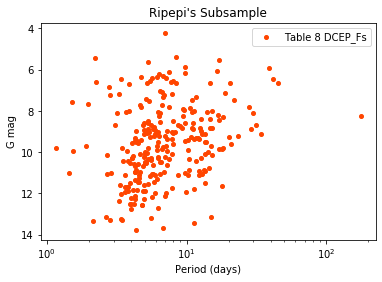

In [12]:
plt.scatter(subsamp_pers,subsamp_mags,c='orangered',s=16,label='Table 8 DCEP_Fs')# (N='+str(len(subsamp_pers))+')')
#plt.errorbar(subsamp_pers,subsamp_mags, yerr=subsamp_mag_errors, ls='None', ecolor='k', capsize=2)
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title("Ripepi's Subsample")
plt.xlabel('Period (days)')
plt.ylabel('G mag')
plt.legend()
plt.show()

In [13]:
###Create function we want to Fourier fit
def PL(x,alpha,beta):
    Wa = alpha + beta*np.log10(x)
    return 10**(0.2*Wa)

###Now do the fits
#fit_pl = curve_fit(PL, subsamp_pers, subsamp_mags)
#fitspan = np.linspace(min(subsamp_pers),max(subsamp_pers),num=2**16)
#fitcurve = PL(fitspan, *fit_pl[0])
#fit_pl[0]

In [14]:
#plt.figure(figsize=(12.5,5)) 
#plt.scatter(subsamp_pers,subsamp_mags,c='orangered',s=16)# (N='+str(len(subsamp_pers))+')')
#plt.plot(fitspan, fitcurve, c='k')
#plt.errorbar()
#plt.gca().invert_yaxis()
#plt.xscale('log')
#plt.title("Ripepi's Subsample")
#plt.xlabel('Period (days)')
#plt.ylabel('G mag')
#plt.savefig('Ripepi.png', bbox_inches='tight', dpi=300)
#plt.show()

In [15]:
print(np.argwhere(subsamp_ID[0]== mw_IDs)[0][0])
subsamp_ID[0] == mw_IDs[1697]

1697


True

In [16]:
mw_IDs = np.loadtxt('ripepi_table5.txt',usecols=(0), dtype=np.int64)
mw_per = np.loadtxt('ripepi_table5.txt',usecols=(6))
mw_mag = np.loadtxt('ripepi_table5.txt',usecols=(7))
mw_parallax = np.loadtxt('ripepi_table5.txt',usecols=(14))

absolute_mags = []
absolute_pers = []
for i in range(0,len(subsamp_ID)):
    index = np.argwhere(subsamp_ID[i]== mw_IDs)[0][0]
    d = 1/(mw_parallax[index]/1000)
    m = mw_mag[index]
    M = m - 5*np.log10(d) + 5
    if np.isnan(M) == True:
        continue
    per = mw_per[index]
    absolute_mags.append(M)
    absolute_pers.append(per)

len(absolute_mags)# == len(absolute_pers)

D:\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


297

In [17]:
def PL(x,alpha,beta):
    Wa = alpha + beta*np.log10(x)
    return Wa #10**(0.2*Wa)

fit_pl = curve_fit(PL, absolute_pers, absolute_mags)
results = fit_pl[0]
print('alpha = '+str(results[0]))
print('beta  = '+str(results[1]))

alpha = -1.3282672335404637
beta  = -1.9862059474971936


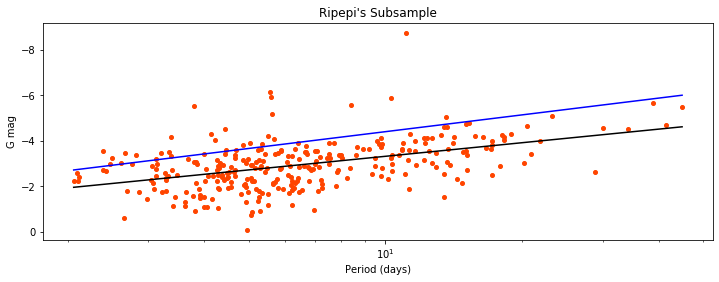

In [18]:
fitspan = np.linspace(min(absolute_pers),max(absolute_pers),num=2**16)
fitcurve = PL(fitspan, *fit_pl[0])
rip_a = -1.942
rip_b = -2.454
plt.figure(figsize=(12,4)) 
plt.scatter(absolute_pers,absolute_mags,c='orangered',s=16)# (N='+str(len(subsamp_pers))+')')
plt.plot(fitspan, fitcurve, c='k')
plt.plot(fitspan, rip_a+(rip_b*np.log10(fitspan)), c='b')
#plt.errorbar()
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title("Ripepi's Subsample")
plt.xlabel('Period (days)')
plt.ylabel('G mag')
#plt.savefig('Ripepi_compare.png', bbox_inches='tight', dpi=300)
plt.show()

In [19]:
max(absolute_mags)

-0.08200150898458958

## Comparision Plots for Different Magnitudes

In [44]:
def CompareMags(lc_file):
    """
    
    Inputs: 
    'lc_file', downloaded text file of Gaia DR2 light curve data(String).
    
    Outputs: 
    """
    
    ###Important constants
    zp = 25.6883657251 #Gaia DR2 zero point
    mean_fluxs = []
    mean_mags = []
    c_mags = []
    c_fluxs = []
    wf_mags = []
    wf_fluxs = []
    mag_tables = []
    gis_mags = []
    sources = []
    for i in range(0, len(lc_file)):
        source_id = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
        ceph_source = source_id[0]
        per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
        per_table = per_table[0][0]
        if str(per_table) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_source)]
        mag_table = mag_table[0][0]
        
        ###Retreving and sorting light curve properties from downloaded Gaia files
        lcs = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
        band = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=2, dtype=np.str)
        time = lcs[:,0]
        mag = lcs[:,1]
        flux = lcs[:,2]
        flux_error = lcs[:,3]
        
        ###Seperating source properties by band
        G_ind = np.argwhere(band=='G')
        time_G = time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
        flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]
        mag_error_G = (2.5/np.log(10))*flux_error_G/flux_G
        phase = time_G % per_table
    
        ###Create function we want to Fourier fit
        def SevDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,C):
            per = per_table
            deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
            deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
            deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
            deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
            deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
            deg6 = (np.sin(2*np.pi*6*x/per)*amp11) + (np.cos(2*np.pi*6*x/per)* amp12)
            deg7 = (np.sin(2*np.pi*7*x/per)*amp13) + (np.cos(2*np.pi*7*x/per)* amp14)
            return C + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        
        ###Generation of "first guesses" for our Fourier fit function for flux.
        guess_freq = 1
        guess_amp = 3*np.std(flux_G)/(2**0.5)
        guess_C = np.mean(flux_G)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
        
        ###Repeat for magnitude.
        guess_freq2 = 1
        guess_amp2 = 3*np.std(mag_G)/(2**0.5)
        guess_C2 = np.mean(mag_G)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_C2]
        
        ###Now do the fits
        fit_flux = curve_fit(SevDegFit, phase, flux_G, p0=p0, sigma=flux_error_G, absolute_sigma=True)
        fit_mag = curve_fit(SevDegFit, phase, mag_G, p0=p02, sigma=mag_error_G, absolute_sigma=True)
        x = np.linspace(min(phase),max(phase),num=2**16)
        fitcurve_flux = SevDegFit(x, *fit_flux[0])
        fitcurve_mag = SevDegFit(x, *fit_mag[0])
        
        ###Weighted mean of Gaia magnitude points and fitted magnitude curve.
        weights = []
        weights2 = []
        for j in range(0, len(mag_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            distance = flux_G[j] - fitcurve_flux[fit_ind]
            distance2 = mag_G[j] - fitcurve_mag[fit_ind]
            #weight = 1/((np.abs(distance)+0.002)**2)
            weight = 1/(flux_error_G)**2
            #weight2 = 1/((np.abs(distance2)+0.002)**2)
            weight2 = 1/(mag_error_G)**2
            weights.append(weight)
            weights2.append(weight2)
        #wf_flux = np.average(flux_G, weights=weights)
        wf_flux = np.average(flux_G, weights=1/(flux_error_G)**2)
        wf_flux_conv = zp - 2.5*np.log10(wf_flux)
        #wf_mag = np.average(mag_G, weights=weights2)
        wf_mag = np.average(mag_G, weights=1/(mag_error_G)**2)
        
        #Stuff to print
        C_mag = fit_mag[0][-1]
        C_flux = fit_flux[0][-1]
        C_flux_conv = zp - 2.5*np.log10((C_flux))

        med = np.median(zp - 2.5*np.log10(flux_G))
        mea = zp - 2.5*np.log10(np.mean(flux_G))
        med2 = np.median(mag_G)
        mea2 = np.mean(mag_G)
       
        #Gisella int av mag
        gis_flux = 10**((zp - fitcurve_mag)/2.5)
        gis_flux_mean = np.mean(gis_flux)
        gis_mag = zp - 2.5*np.log10(gis_flux_mean)

        #print('C_mag             = '+str(C_mag))
        #print('C_flux            = '+str(C_flux_conv))
        #print('WF_mag            = '+str(wf_mag))
        #print('Mean_flux         = '+str(mea))
        #print('Mean_mag          = '+str(mea2))
        #print('int_avg_mag_DR2   = '+str(mag_table))
        #print('int_avg_mag_shown = '+str(gis_mag))
        
        mean_fluxs.append(mea)
        mean_mags.append(mea2)
        c_mags.append(C_mag)
        c_fluxs.append(C_flux_conv)
        wf_mags.append(wf_mag)
        wf_fluxs.append(wf_flux_conv)
        mag_tables.append(mag_table)
        gis_mags.append(gis_mag)
        sources.append(ceph_source)
    #print(str(len(mag_tables))+'/'+str(len(lc_file)))
    
    def colorkey(a_flux, a_mag):
        keys = []
        for j in range(0,len(a_flux)):
            if a_flux[j] > a_mag[j]:
                key = 'r'
            else:
                key = 'b'
            keys.append(key)
        return keys
    typical_mean = -np.mean(mean_fluxs)+np.mean(mean_mags)
    print(typical_mean)
    for k in range(0,len(mean_fluxs)):
        print(str(sources[k])+'   '+str(-mean_fluxs[k]+mean_mags[k]))
    #print('Typical = '+str(np.mean(mean_fluxs-mean_mags)))
    diag = np.linspace(min(mean_fluxs),max(mean_fluxs),120)
    plt.plot(diag,diag,c='k',ls='--')
    plt.scatter(mean_fluxs, mean_mags, marker='o', c=colorkey(mean_fluxs,mean_mags),alpha=0.5)
    plt.title('Arthmetic Mean Magnitudes')
    plt.xlabel('Converted Flux')
    plt.ylabel('Magnitude')
    #plt.legend(loc="upper left")
    plt.axis('scaled')
    plt.xlim(15,16)
    plt.ylim(15,16)
    #plt.savefig('Arthmetic_Mean_zoom.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    typical = -np.mean(c_fluxs)+np.mean(c_mags)
    print(typical)
    for k in range(0,len(c_fluxs)):
        print(str(sources[k])+'   '+str(-c_fluxs[k]+c_mags[k]))
    diag = np.linspace(min(c_fluxs),max(c_fluxs),120)
    plt.plot(diag,diag,c='k',ls='--')
    plt.scatter(c_fluxs, c_mags, marker='o', c=colorkey(c_fluxs,c_mags),alpha=0.5)
    plt.title('Fourier Fit Constant Terms')
    plt.xlabel('Converted Flux')
    plt.ylabel('Magnitude')
    plt.axis('scaled')
    plt.xlim(15,16)
    plt.ylim(15,16)
    #plt.savefig('Fit_C_zoom.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    typical = -np.mean(wf_fluxs)+np.mean(wf_mags)
    print(typical)
    for k in range(0,len(wf_fluxs)):
        print(str(sources[k])+'   '+str(-wf_fluxs[k]+wf_mags[k]))
    diag = np.linspace(min(wf_fluxs),max(wf_fluxs),120)
    plt.plot(diag,diag,c='k',ls='--')
    plt.scatter(wf_fluxs, wf_mags, marker='o', c=colorkey(wf_fluxs,wf_mags),alpha=0.5)
    plt.title('Weighted Mean Magnitudes')
    plt.xlabel('Converted Flux')
    plt.ylabel('Magnitude')
    plt.axis('scaled')
    #plt.xlim(15,16)
    #plt.ylim(15,16)
    #plt.savefig('Weighted_Mean.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    typical = -np.mean(mag_tables)+np.mean(gis_mags)
    print(typical)
    for k in range(0,len(mag_tables)):
        print(str(sources[k])+'   '+str(-mag_tables[k]+gis_mags[k]))
    diag = np.linspace(min(mag_tables),max(mag_tables),120)
    plt.plot(diag,diag,c='k',ls='--')
    plt.scatter(mag_tables, gis_mags, marker='o', c=colorkey(mag_tables,gis_mags),alpha=0.5)
    plt.title('Intensity-Averaged Magnitudes')
    plt.xlabel('Calculated')
    plt.ylabel('Published')
    plt.axis('scaled')
    plt.xlim(15,16)
    plt.ylim(15,16)
    #plt.savefig('Int_Avg_zoom.png', bbox_inches='tight', dpi=300)
    plt.show()

0.01751717391390173
4659494849927324288   0.02468392246091966
4659661632076538752   0.020117345504036876
4660422150542501504   0.012246870029068546
4660537698007124480   0.025392011350364285
4661781868464576512   0.028889438958156433
4661959748834771840   0.0253143702006291
4662030048864250624   0.02235435129217045
4662093683088745600   0.008846336767518892
4663622004241681280   0.016174982093524193
4663622004241681408   0.014787883520860134
506581226385580288   0.02708688182677399
506602976101284736   0.019936068218569858
509629965971797376   0.00819488716449257
5853170268450896768   0.01293267531768727
5932569709575669504   0.003978779100364704
5932997939411720960   0.00933797881731202


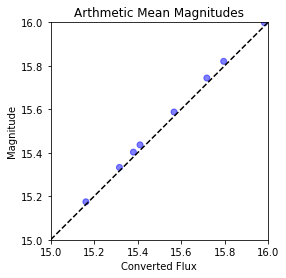

0.017810993710060785
4659494849927324288   0.026674118781070177
4659661632076538752   0.023014979768168686
4660422150542501504   0.012921154795563439
4660537698007124480   0.024934880163419493
4661781868464576512   0.029389649514723004
4661959748834771840   0.027375822367453395
4662030048864250624   0.021994285850389872
4662093683088745600   0.01040733118137993
4663622004241681280   0.017379582184368303
4663622004241681408   0.015971956069213533
506581226385580288   0.023211994653594914
506602976101284736   0.018793974453583218
509629965971797376   0.009620146920193307
5853170268450896768   0.011011435868994113
5932569709575669504   0.0032407766542590366
5932997939411720960   0.009033810134585707


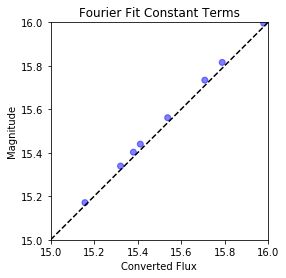

-0.047255518927700635
4659494849927324288   -0.07563331396253403
4659661632076538752   -0.05357149910310355
4660422150542501504   -0.035363626890699607
4660537698007124480   -0.083837197650098
4661781868464576512   -0.06811707105900311
4661959748834771840   -0.06349875323946286
4662030048864250624   -0.06821235253893398
4662093683088745600   -0.029551465495117668
4663622004241681280   -0.04499268128614453
4663622004241681408   -0.04816323619304974
506581226385580288   -0.05000093113305759
506602976101284736   -0.04033587004182415
509629965971797376   -0.02377049595615155
5853170268450896768   -0.03543702239048052
5932569709575669504   -0.012087352308535415
5932997939411720960   -0.02351543359502628


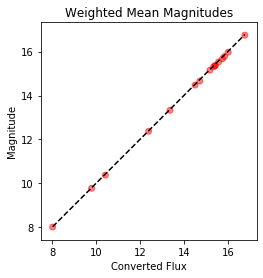

-0.002673841630858931
4659494849927324288   -0.006048588193586113
4659661632076538752   -0.003708910061622106
4660422150542501504   0.0015488169715442979
4660537698007124480   0.0018035604370023606
4661781868464576512   0.000501961497747061
4661959748834771840   -0.004540685078017859
4662030048864250624   -0.001321744518799406
4662093683088745600   -0.0037568592994645655
4663622004241681280   -0.0013888453472024054
4663622004241681408   -0.006095767292684684
506581226385580288   -0.0014267889242436382
506602976101284736   -0.005967224533440785
509629965971797376   -0.0007722738183062461
5853170268450896768   -0.0009247456679286614
5932569709575669504   -0.005063862419376619
5932997939411720960   -0.005619509845363524


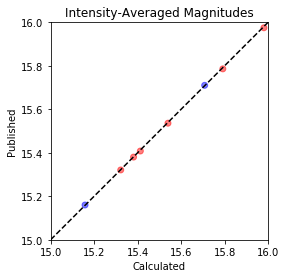

In [45]:
#%matplotlib notebook
files = glob.glob('lc_*.txt')
CompareMags(files)

In [34]:
def CompareMags2(lc_file):
    """
    
    Inputs: 
    'lc_file', downloaded text file of Gaia DR2 light curve data(String).
    
    Outputs: 
    """
    
    ###Important constants
    zp = 25.6883657251 #Gaia DR2 zero point
    mean_fluxs = []
    mean_mags = []
    c_mags = []
    c_fluxs = []
    wf_mags = []
    wf_fluxs = []
    mag_tables = []
    gis_mags = []
    for i in range(0, len(lc_file)):
        source_id = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
        ceph_source = source_id[0]
        per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
        per_table = per_table[0][0]
        if str(per_table) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_source)]
        mag_table = mag_table[0][0]
        
        ###Retreving and sorting light curve properties from downloaded Gaia files
        lcs = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
        band = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=2, dtype=np.str)
        time = lcs[:,0]
        mag = lcs[:,1]
        flux = lcs[:,2]
        flux_error = lcs[:,3]
        
        ###Seperating source properties by band
        G_ind = np.argwhere(band=='G')
        time_G = time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
        flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]
        mag_error_G = (2.5/np.log(10))*flux_error_G/flux_G
        phase = time_G % per_table
    
        ###Create function we want to Fourier fit
        def SevDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,C):
            per = per_table
            deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
            deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
            deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
            deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
            deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
            deg6 = (np.sin(2*np.pi*6*x/per)*amp11) + (np.cos(2*np.pi*6*x/per)* amp12)
            deg7 = (np.sin(2*np.pi*7*x/per)*amp13) + (np.cos(2*np.pi*7*x/per)* amp14)
            return C + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        
        ###Generation of "first guesses" for our Fourier fit function for flux.
        guess_freq = 1
        guess_amp = 3*np.std(flux_G)/(2**0.5)
        guess_C = np.mean(flux_G)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
        
        ###Repeat for magnitude.
        guess_freq2 = 1
        guess_amp2 = 3*np.std(mag_G)/(2**0.5)
        guess_C2 = np.mean(mag_G)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_C2]
        
        ###Now do the fits
        fit_flux = curve_fit(SevDegFit, phase, flux_G, p0=p0, sigma=flux_error_G, absolute_sigma=True)
        fit_mag = curve_fit(SevDegFit, phase, mag_G, p0=p02, sigma=mag_error_G, absolute_sigma=True)
        x = np.linspace(min(phase),max(phase),num=2**16)
        fitcurve_flux = SevDegFit(x, *fit_flux[0])
        fitcurve_mag = SevDegFit(x, *fit_mag[0])
        
        ###Weighted mean of Gaia magnitude points and fitted magnitude curve.
        weights = []
        weights2 = []
        for j in range(0, len(mag_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            distance = flux_G[j] - fitcurve_flux[fit_ind]
            distance2 = mag_G[j] - fitcurve_mag[fit_ind]
            weight = 1/((np.abs(distance)+0.002)**2)
            weight2 = 1/((np.abs(distance2)+0.002)**2)
            weights.append(weight)
            weights2.append(weight2)
        wf_flux = np.average(flux_G, weights=weights)
        wf_flux_conv = zp - 2.5*np.log10(wf_flux)
        wf_mag = np.average(mag_G, weights=weights2)
        
        #Stuff to print
        C_mag = fit_mag[0][-1]
        C_flux = fit_flux[0][-1]
        C_flux_conv = zp - 2.5*np.log10((C_flux))

        med = np.median(zp - 2.5*np.log10(flux_G))
        mea = zp - 2.5*np.log10(np.mean(flux_G))
        med2 = np.median(mag_G)
        mea2 = np.mean(mag_G)
       
        #Gisella int av mag
        gis_flux = 10**((zp - fitcurve_mag)/2.5)
        gis_flux_mean = np.mean(gis_flux)
        gis_mag = zp - 2.5*np.log10(gis_flux_mean)

        print('C_mag             = '+str(C_mag))
        print('C_flux            = '+str(C_flux_conv))
        print(C_flux_conv-C_mag)
        print('WF_mag            = '+str(wf_mag))
        print('WF_flux           = '+str(wf_flux_conv))
        print(wf_flux_conv-wf_mag)
        print('Mean_flux         = '+str(mea))
        print('Mean_mag          = '+str(mea2))
        print(mea-mea2)
        print('int_avg_mag_DR2   = '+str(mag_table))
        print('int_avg_mag_shown = '+str(gis_mag))
        print(mag_table-gis_mag)
        
        plt.scatter(mea, mea2, marker='o', c='k',alpha=0.5, label='Arithmetic Mean')
        plt.scatter(wf_flux_conv, wf_mag, marker='o', c='b',alpha=0.5, label='Weighted Mean')
        plt.scatter(C_flux_conv, C_mag, marker='o', c='r',alpha=0.5, label='Fourier Fit Constant')
        plt.scatter(gis_mag, mag_table, marker='o', c='g',alpha=0.5, label='Intensity-Averaged')
        plt.title('Magnitudes of Cepheid '+str(ceph_source))
        plt.xlabel('Value 1') #('In terms of converted flux')
        plt.ylabel('Value 2') #('In terms of magnitude')
        megalist = np.hstack((mea,mea2,wf_flux_conv,wf_mag,C_flux_conv,C_mag,gis_mag,mag_table))
        dom = np.linspace(min(megalist),max(megalist))
        plt.plot(dom,dom,c='k',ls='--')
        plt.xlim(min(megalist)-000.1,max(megalist+000.1))
        plt.ylim(min(megalist)-000.1,max(megalist+000.1))
        plt.legend(fontsize='small')
        plt.axis('scaled')
        #plt.savefig('Mags_For_'+str(ceph_source)+'.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        mean_fluxs.append(mea)
        mean_mags.append(mea2)
        c_mags.append(C_mag)
        c_fluxs.append(C_flux_conv)
        wf_mags.append(wf_mag)
        wf_fluxs.append(wf_flux_conv)
        mag_tables.append(mag_table)
        gis_mags.append(gis_mag)
        
        
    #plt.scatter(c_fluxs, c_mags, marker='o', c='r')
    #plt.title('Fourier Fit Constant Terms')
    #plt.xlabel('Converted Flux')
    #plt.ylabel('Magnitude')
    #plt.show()

C_mag             = 15.815907039276631
C_flux            = 15.78923292049556
-0.026674118781070177
WF_mag            = 16.00638088532392
WF_flux           = 16.005430924413186
-0.0009499609107344043
Mean_flux         = 15.796120708073135
Mean_mag          = 15.820804630534054
-0.02468392246091966
int_avg_mag_DR2   = 15.792224572310262
int_avg_mag_shown = 15.786175984116676
0.006048588193586113


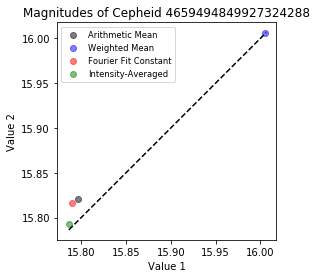

C_mag             = 15.56152230291769
C_flux            = 15.53850732314952
-0.023014979768168686
WF_mag            = 15.835075652077947
WF_flux           = 15.840466714473557
0.005391062395609936
Mean_flux         = 15.567713271997398
Mean_mag          = 15.587830617501435
-0.020117345504036876
int_avg_mag_DR2   = 15.539929643571835
int_avg_mag_shown = 15.536220733510213
0.003708910061622106


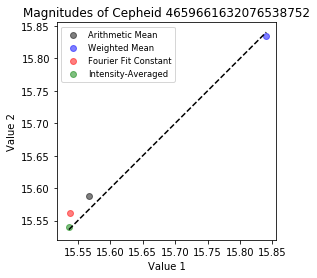

C_mag             = 15.170984571813477
C_flux            = 15.158063417017914
-0.012921154795563439
WF_mag            = 15.010510474204148
WF_flux           = 15.01013719994165
-0.00037327426249866846
Mean_flux         = 15.162493927907507
Mean_mag          = 15.174740797936575
-0.012246870029068546
int_avg_mag_DR2   = 15.158521789860682
int_avg_mag_shown = 15.160070606832226
-0.0015488169715442979


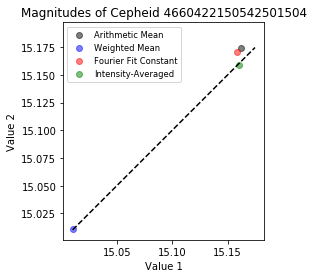

C_mag             = 15.7342418991263
C_flux            = 15.70930701896288
-0.024934880163419493
WF_mag            = 15.612244960600494
WF_flux           = 15.612364769814734
0.00011980921424026292
Mean_flux         = 15.718714910836042
Mean_mag          = 15.744106922186406
-0.025392011350364285
int_avg_mag_DR2   = 15.708662910364277
int_avg_mag_shown = 15.71046647080128
-0.0018035604370023606


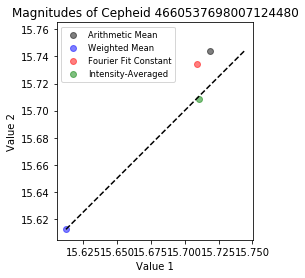

C_mag             = 14.728578751104067
C_flux            = 14.699189101589344
-0.029389649514723004
WF_mag            = 14.56087903063234
WF_flux           = 14.56051560561468
-0.0003634250176585141
Mean_flux         = 14.657300400176407
Mean_mag          = 14.686189839134563
-0.028889438958156433
int_avg_mag_DR2   = 14.702845603591062
int_avg_mag_shown = 14.703347565088809
-0.000501961497747061


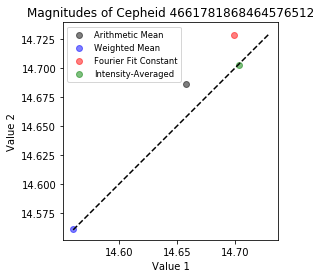

C_mag             = 15.440025355328316
C_flux            = 15.412649532960863
-0.027375822367453395
WF_mag            = 15.725021767460836
WF_flux           = 15.725694208448843
0.0006724409880067839
Mean_flux         = 15.411368592984354
Mean_mag          = 15.436682963184984
-0.0253143702006291
int_avg_mag_DR2   = 15.41281505928321
int_avg_mag_shown = 15.408274374205192
0.004540685078017859


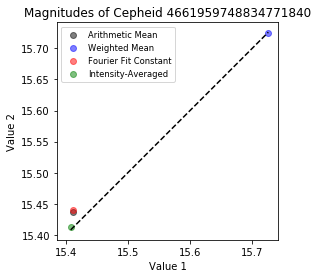

C_mag             = 15.402972966144102
C_flux            = 15.380978680293712
-0.021994285850389872
WF_mag            = 15.427871011567618
WF_flux           = 15.428940965172552
0.0010699536049347813
Mean_flux         = 15.38090813556192
Mean_mag          = 15.403262486854091
-0.02235435129217045
int_avg_mag_DR2   = 15.381679197543239
int_avg_mag_shown = 15.38035745302444
0.001321744518799406


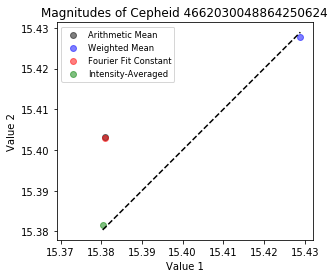

C_mag             = 16.745109850149976
C_flux            = 16.734702518968597
-0.01040733118137993
WF_mag            = 16.917324008411587
WF_flux           = 16.91838697082231
0.001062962410724566
Mean_flux         = 16.75949228090344
Mean_mag          = 16.76833861767096
-0.008846336767518892
int_avg_mag_DR2   = 16.73582275629625
int_avg_mag_shown = 16.732065896996787
0.0037568592994645655


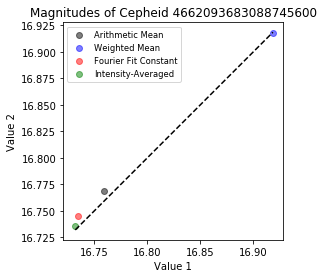

C_mag             = 15.339225344828469
C_flux            = 15.3218457626441
-0.017379582184368303
WF_mag            = 15.360076186667568
WF_flux           = 15.360196592561095
0.00012040589352757536
Mean_flux         = 15.316722895875424
Mean_mag          = 15.332897877968948
-0.016174982093524193
int_avg_mag_DR2   = 15.322618716238352
int_avg_mag_shown = 15.32122987089115
0.0013888453472024054


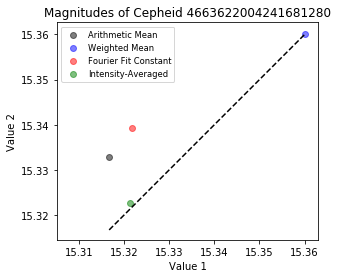

C_mag             = 15.996055100209423
C_flux            = 15.98008314414021
-0.015971956069213533
WF_mag            = 16.204114047868796
WF_flux           = 16.204971222314747
0.0008571744459509034
Mean_flux         = 15.983357336838628
Mean_mag          = 15.998145220359488
-0.014787883520860134
int_avg_mag_DR2   = 15.981213054888809
int_avg_mag_shown = 15.975117287596124
0.006095767292684684


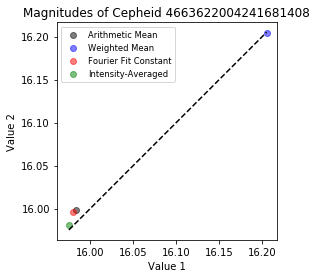

C_mag             = 10.324185276309072
C_flux            = 10.300973281655477
-0.023211994653594914
WF_mag            = 10.362094259435677
WF_flux           = 10.363574365905048
0.001480106469371023
Mean_flux         = 10.287326310233759
Mean_mag          = 10.314413192060533
-0.02708688182677399
int_avg_mag_DR2   = 10.301657881316093
int_avg_mag_shown = 10.300231092391849
0.0014267889242436382


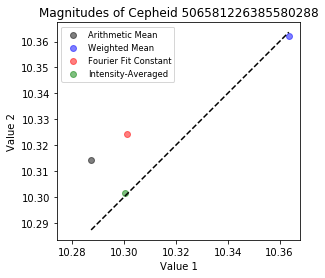

C_mag             = 13.210902712818358
C_flux            = 13.192108738364775
-0.018793974453583218
WF_mag            = 13.43079711679764
WF_flux           = 13.43014986597405
-0.0006472508235901842
Mean_flux         = 13.228078510528452
Mean_mag          = 13.248014578747021
-0.019936068218569858
int_avg_mag_DR2   = 13.191810946301487
int_avg_mag_shown = 13.185843721768046
0.005967224533440785


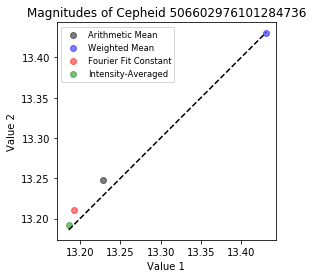

C_mag             = 12.341872207476662
C_flux            = 12.332252060556469
-0.009620146920193307
WF_mag            = 12.31915591169259
WF_flux           = 12.319151285412428
-4.6262801625118755e-06
Mean_flux         = 12.313848574646578
Mean_mag          = 12.32204346181107
-0.00819488716449257
int_avg_mag_DR2   = 12.333029091988532
int_avg_mag_shown = 12.332256818170226
0.0007722738183062461


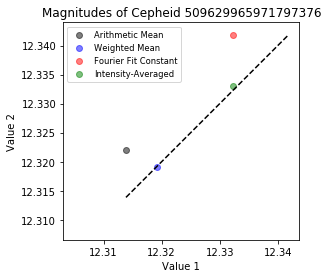

C_mag             = 14.445220653253344
C_flux            = 14.43420921738435
-0.011011435868994113
WF_mag            = 14.454329375425754
WF_flux           = 14.453807022891173
-0.0005223525345812163
Mean_flux         = 14.470136901849845
Mean_mag          = 14.483069577167532
-0.01293267531768727
int_avg_mag_DR2   = 14.435028683552273
int_avg_mag_shown = 14.434103937884345
0.0009247456679286614


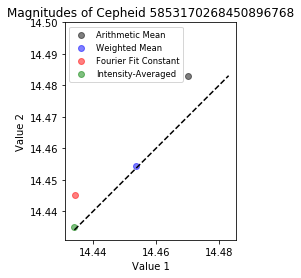

C_mag             = 7.976313387547801
C_flux            = 7.973072610893542
-0.0032407766542590366
WF_mag            = 7.929620546319291
WF_flux           = 7.928695494840575
-0.0009250514787160213
Mean_flux         = 8.010275015401557
Mean_mag          = 8.014253794501922
-0.003978779100364704
int_avg_mag_DR2   = 7.982944730790841
int_avg_mag_shown = 7.977880868371464
0.005063862419376619


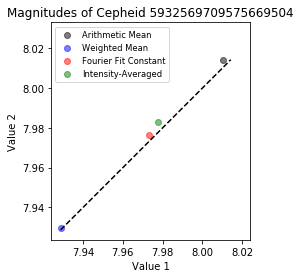

C_mag             = 9.797320193998452
C_flux            = 9.788286383863866
-0.009033810134585707
WF_mag            = 9.8910257666377
WF_flux           = 9.890317419566667
-0.0007083470710327333
Mean_flux         = 9.75582777342764
Mean_mag          = 9.765165752244952
-0.00933797881731202
int_avg_mag_DR2   = 9.789386673199012
int_avg_mag_shown = 9.783767163353648
0.005619509845363524


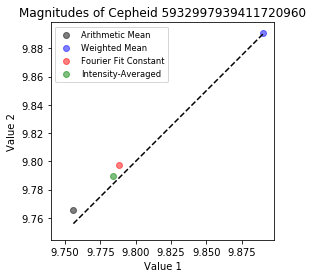

In [35]:
files = glob.glob('lc_*.txt')
CompareMags2(files)

In [24]:
testy = np.array([2,4,16,65536])
testy = np.delete(testy,2)
testy

array([    2,     4, 65536])

## Light Curver

In [25]:
def LightCurver(lc_file):
    """
    
    Inputs: 
    'lc_file', a downloaded text file of Gaia DR2 light curve data for one star (String).
    
    Outputs: 
    Light curve figure in terms of flux.
    Light curve figure in terms of magnitude.
    """
    
    ###Important constants
    zp = 25.6883657251 #Gaia DR2 zero point
    
    #for i in range(0, len(ceph_sources)):
    source_id = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    ceph_source = source_id[0]
    per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
    per_table = per_table[0][0]
    mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_source)]
    mag_table = mag_table[0][0]
        
    ###Retreving and sorting light curve properties from downloaded Gaia files
    lcs = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    band = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3]
        
    ###Seperating source properties by band
    G_ind = np.argwhere(band=='G')
    time_G = time[G_ind[0][0]:G_ind[-1][0]]
    mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
    flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
    flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]
    mag_error_G = (2.5/np.log(10))*flux_error_G/flux_G
    phase = time_G % per_table
    #print(flux_error_G)
    #print(max(flux_error_G))
    
    ###Removing outliers
    #norm = np.abs((flux_error_G - np.mean(flux_error_G))/iqr(flux_error_G))
    #for j in range(0,len(norm)):
        #if norm[j] > 5:
            #norm_new = np.delete(norm,j) #Must delete at correct index of original array.
    
    ###Create function we want to Fourier fit
    def SevDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,C):
        per = per_table
        deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
        deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
        deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
        deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
        deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
        deg6 = (np.sin(2*np.pi*6*x/per)*amp11) + (np.cos(2*np.pi*6*x/per)* amp12)
        deg7 = (np.sin(2*np.pi*7*x/per)*amp13) + (np.cos(2*np.pi*7*x/per)* amp14)
        return C + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        
    ###Generation of "first guesses" for our Fourier fit function for flux.
    guess_freq = 1
    guess_amp = 3*np.std(flux_G)/(2**0.5)
    guess_C = np.mean(flux_G)
    p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
        
    ###Repeat for magnitude.
    guess_freq2 = 1
    guess_amp2 = 3*np.std(mag_G)/(2**0.5)
    guess_C2 = np.mean(mag_G)
    p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_C2]
        
    ###Now do the fits
    fit_flux = curve_fit(SevDegFit, phase, flux_G, p0=p0, sigma=flux_error_G, absolute_sigma=True)
    fit_mag = curve_fit(SevDegFit, phase, mag_G, p0=p02, sigma=mag_error_G, absolute_sigma=True)
    x = np.linspace(min(phase),max(phase),num=2**16)
    fitcurve_flux = SevDegFit(x, *fit_flux[0])
    fitcurve_mag = SevDegFit(x, *fit_mag[0])
        
    ###Weighted mean of Gaia magnitude points and fitted magnitude curve.
    #distances = []
    weights = []
    weights2 = []
    #chi2s = []
    for j in range(0, len(mag_G)):
        phase_value = phase[j]
        fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
        fit_ind = int(fit_ind)
        distance = flux_G[j] - fitcurve_flux[fit_ind]
        distance2 = mag_G[j] - fitcurve_mag[fit_ind]
        weight = 1/((np.abs(distance)+0.002)**2)
        weight2 = 1/((np.abs(distance2)+0.002)**2)
        #chi2 = chisquare(f_obs=mag_G, f_exp=fitcurve_mag[fit_ind])
        #distances.append(distance)
        weights.append(weight)
        weights2.append(weight2)
        #chi2s.append(chi2)
    #wf_og = np.average(flux_G, weights=weights)
    #wf_mag_og = zp - 2.5*np.log10(wf)
    #chi2_mean = np.mean(chi2s)
    wf_flux = np.average(flux_G, weights=weights)
    wf_flux_conv = zp - 2.5*np.log10(wf_flux)
    wf_mag = np.average(mag_G, weights=weights2)
    
    
    #Plotting flux
    plt.figure(figsize=(8,4)) 
    plt.plot(x/per_table, fitcurve_flux, c='k')
    plt.errorbar(phase/per_table, flux_G, yerr=flux_error_G, ls='None', ecolor='k', capsize=2)
    plt.scatter(phase/per_table, flux_G, c='g')
    plt.title('Light Curve for ' + str(ceph_source) +', Per = '+ str('%.3f'%per_table))
    plt.xlabel('Phase')
    plt.ylabel('G Band Flux')
    #plt.savefig('LCfit_'+str(ceph_source)+'_flux.png', bbox_inches='tight', dpi=150)
    plt.show()
        
    #Plotting mag
    plt.figure(figsize=(8,4)) 
    plt.errorbar(phase/per_table, mag_G, yerr=mag_error_G, ls='None', ecolor='k', capsize=2)
    plt.scatter(phase/per_table, mag_G, c='cyan')
    plt.plot(x/per_table, fitcurve_mag, c='k')
    plt.title('Light Curve for ' + str(ceph_source) +', Per = '+ str('%.3f'%per_table))
    plt.xlabel('Phase')
    plt.ylabel('Vega Magnitude')
    plt.gca().invert_yaxis()
    #plt.savefig('LCfit_'+str(ceph_source)+'_mag.png', bbox_inches='tight', dpi=150)
    plt.show()
        
    #Stuff to print
    C_mag = fit_mag[0][-1]
    C_flux = fit_flux[0][-1]
    C_flux_conv = zp - 2.5*np.log10((C_flux))

    med = np.median(zp - 2.5*np.log10(flux_G))
    mea = zp - 2.5*np.log10(np.mean(flux_G))
    med2 = np.median(mag_G)
    mea2 = np.mean(mag_G)
       
    #Gisella int av mag
    gis_flux = 10**((zp - fitcurve_mag)/2.5)
    gis_flux_mean = np.mean(gis_flux)
    gis_mag = zp - 2.5*np.log10(gis_flux_mean)
    
    print('Mean_mag          = '+str(mea2))
    print('Mean_flux         = '+str(mea))
    print('C_mag             = '+str(C_mag))
    print('C_flux            = '+str(C_flux_conv))
    print('WF_mag            = '+str(wf_mag))
    print('WF_flux           = '+str(wf_flux_conv))
    print('int_avg_mag_publ  = '+str(mag_table))
    print('int_avg_mag_calc  = '+str(gis_mag))

In [26]:
test60 = 6499632424888893824
test60f = 'lc_'+str(test60)+'.txt'
#LightCurver(test60f)
#per_table = r['pf'][np.argwhere(r['source_id']==test60)]
#per_table

In [27]:
lc_files = glob.glob('lc_*.txt')
for i in range(0, len(lc_files)):
    source_id = np.loadtxt(lc_files[i],skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    ceph_source = source_id[0]
    per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
    per_table = per_table[0][0]
    if str(per_table) == '--':
        continue
    #LightCurver(lc_files[i])